In [1]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime
from scipy.optimize import minimize

## Group Assignment
### Team Number: 11
### Team Member Names: Akram, Annie, Jester
### Team Strategy Chosen: Market Beat

Disclose any use of AI for this assignment below (detail where and how you used it).  Please see the course outline for acceptable uses of AI.


---
## 📝 **General Strategy for the Project**:

#### Initialization
0) Define and initialize necessary global variables

#### Part #1: Data Filtering and Cleaning
1) Filter out all valid US and CAD Stocks from the provided CSV file (Storing US tickers in another list for currency conversion later on).
2) Download and store closing price, options and volume data in a dictionary using yfinance.
3) Filter out tickers within date range based on given minimum monthly average volume.

#### Part #2: Portfolio Construction
4) Rank stocks based on Standard Deviation of percentage change in returns in descending order.
5) Rank stocks based on PCR values using options data in descending order.
6) Score the stocks based on the two ranks, and create a new ranking based on the scoring.
7) We select stocks based on the ranking and calculate weights that would maximize the portfolio sharpe ratio while beta is within pre-defined constraints.
8) Run sharpe ratio calculation function on portfolio from size 12(min) to 24(max), so that the final portfolio (with weightings) is picked based on highest output sharpe ratio.

#### Part #3: Evaluation and Proof
9) Given the chosen portfolio of xx stocks, graph the change in portfolio standard deviation as other stocks are added.
10) Beta of portfolio compared to the S&P 500.
13) Sharpe ratio between our portfolio with varied weight versus when it is equally weighted.
14) Graphically compare sharpe ratios amongst our portfolio of xx stocks and the portfolios of varying 12-24 stocks.

#### Part #4: Final Output
15) Creating the final portfolio dataframe and CSV.

<br>

--- 

## 🌐 0. Initializing Variables

In [2]:
def get_tickers():
    tickers = pd.read_csv('Tickers.csv')
    ticker_lst = [tickers.columns[0]] + (list(tickers[tickers.columns[0]]))
    return ticker_lst

In [3]:
'''
# Get the current date
current_date = datetime.now()

# Calculate start_date: 2 years and 1 month before the current date
start_year = current_date.year - 2
start_month = current_date.month - 1
if start_month == 0:  # Handle crossing the year boundary
    start_month = 12
    start_year -= 1

start_date = f"{start_year:04d}-{start_month:02d}-{current_date.day:02d}"

# Calculate end_date: 1 month before the current date
end_year = current_date.year
end_month = current_date.month - 1
if end_month == 0:  # Handle crossing the year boundary
    end_month = 12
    end_year -= 1

end_date = f"{end_year:04d}-{end_month:02d}-{current_date.day:02d}"
'''

'\n# Get the current date\ncurrent_date = datetime.now()\n\n# Calculate start_date: 2 years and 1 month before the current date\nstart_year = current_date.year - 2\nstart_month = current_date.month - 1\nif start_month == 0:  # Handle crossing the year boundary\n    start_month = 12\n    start_year -= 1\n\nstart_date = f"{start_year:04d}-{start_month:02d}-{current_date.day:02d}"\n\n# Calculate end_date: 1 month before the current date\nend_year = current_date.year\nend_month = current_date.month - 1\nif end_month == 0:  # Handle crossing the year boundary\n    end_month = 12\n    end_year -= 1\n\nend_date = f"{end_year:04d}-{end_month:02d}-{current_date.day:02d}"\n'

In [4]:
# Important Constants: 
amount = 1_000_000 # Initial investment amount of $1,000,000
group = 11

# Define constants
min_avg_volume = 100000
min_trading_days = 18
min_stocks, max_stocks = 12, 24
start_date, end_date = "2022-09-30", "2024-09-30"

# Reading in CSV file: 
ticker_lst = get_tickers()

# Initializing variable to store the tickers we will use in our portfolio
columns = ['Ticker', 'Price', 'Currency', 'Shares', 'Value', 'Weight']
Portfolio_Final = pd.DataFrame(columns=columns)
exchange_rate = yf.Ticker('CAD=X').fast_info['last_price']
print(f'The current exchange rate for the latest available day:\nUSD -> CAD: ${np.round(exchange_rate, 4)}')

The current exchange rate for the latest available day:
USD -> CAD: $1.3977


---
## 🧼 1. Data Filtering and Cleaning

#### We must filter the tickers csv as follows:
- Must be listed on yfinance
- The currency is listed as USD or CAD 
- 100,000+ average monthly volume trades
- More than 18 trades per month
- Sufficient data

In [5]:
# Filtering valid stocks by inputting a list of strings for each ticker. 
def filter_stocks(ticker_lst):
    # Function to drop short trading months (less than 18 trading days per month)
    def drop_short_trading_months(df):
        """
        Drops months with less than 18 trading days from a yfinance history DataFrame.
        Parameters:
            df (pd.DataFrame): A yfinance DataFrame with a DatetimeIndex and stock data.
        Returns:
            pd.DataFrame: Filtered DataFrame with only months having >= 18 trading days.
        """
        # Ensure the index is a DatetimeIndex
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("The DataFrame index must be a DatetimeIndex.")
        # Remove timezone information to avoid warnings
        df = df.copy()  # Avoid modifying the original DataFrame
        df.index = df.index.tz_localize(None)
        # Group by year and month
        df['YearMonth'] = df.index.to_period('M')  # Creates a 'YearMonth' period
        # Count trading days for each month
        trading_days_per_month = df.groupby('YearMonth').size()
        # Get valid months with at least 18 trading days
        valid_months = trading_days_per_month[trading_days_per_month >= 18].index
        # Filter DataFrame to include only rows in valid months
        filtered_df = df[df['YearMonth'].isin(valid_months)].drop(columns=['YearMonth'])
        return filtered_df
    
    valid_tickers, invalid_tickers, usdstocks = {}, [], []
    # Loop through all tickers to check if they are valid
    for ticker in ticker_lst:
        stock = yf.Ticker(ticker)
        try:
            info = stock.fast_info # Get basic stock info

            hist = stock.history(start=start_date, end=end_date) # Get stock history
            pd.to_datetime(hist.index, format='%Y-%m-%d')
            
            avg_volume = hist.loc[((hist.index >= start_date) & (hist.index <= end_date))]['Volume'].mean() # Calculate average volume in specified date range.
            currency = info.get("currency")
            if ((hist.empty is not None) and # filter for stocks delisted on yfinance
                ( currency == "USD" or currency == "CAD") and # filter for stocks that are not USD
                (avg_volume >= min_avg_volume)): # Filter by volume greater than 100,000
                if currency == "CAD":
                    hist = drop_short_trading_months(hist)
                    hist.index = hist.index.strftime('%Y-%m-%d')
                    valid_tickers[ticker] = hist['Close'] # Store the close prices of the stock as a Series
                elif currency == "USD":
                    hist = drop_short_trading_months(hist)
                    hist.index = hist.index.strftime('%Y-%m-%d')
                    usdstocks.append(ticker)
                    valid_tickers[ticker] = hist['Close'] * exchange_rate # Convert USD to CAD
            else:
                invalid_tickers.append(ticker)
        except:
            invalid_tickers.append(ticker)
    return [valid_tickers, invalid_tickers, usdstocks]
    # valid_tickers is a dictionary of Series where the key is the name of the ticker. 
    # invalid_tickers is a list of ticker strings which were removed in the filtering process. 
    # usdstocks is a list of ticker strings which were converted from USD to CAD.

In [6]:
# Loading data into variables
stock_filter = filter_stocks(ticker_lst)
ticker_data = stock_filter[0]
ticker_lst = list(ticker_data.keys()) # Reassign original ticker list
data = pd.DataFrame()
for ticker in ticker_data:
    data[ticker] = ticker_data[ticker]

# returns = data.pct_change()
# returns.drop(index=returns.index[0], inplace = True)

data.head()

$AGN: possibly delisted; no timezone found
$AGN: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$CELG: possibly delisted; no timezone found
$CELG: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$MON: possibly delisted; no timezone found
$MON: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
$RTN: possibly delisted; no timezone found
$RTN: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")


,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BB.TO,...,QCOM,RY.TO,SHOP.TO,T.TO,TD.TO,TXN,UNH,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-03,196.704067,177.464013,133.074915,357.092610,65.700525,161.965467,189.847049,176.180083,41.084940,6.53,...,156.304810,114.575348,37.799999,25.033070,77.623276,208.944669,699.423507,267.001639,207.206715,52.556219
2022-10-04,201.744262,182.172581,137.835233,369.791534,69.080407,169.247482,197.222979,186.606913,42.789659,6.74,...,163.171989,117.543640,42.610001,25.316833,79.079208,215.885929,709.816256,273.828009,214.575649,53.896357
2022-10-05,202.158522,183.891831,138.236377,369.831842,68.532671,169.051805,195.745046,184.650142,42.181777,6.67,...,166.532230,117.041298,41.959999,25.104013,78.620857,219.350129,715.107707,267.481608,213.355946,53.352721
2022-10-06,200.819066,179.991469,136.992819,363.266730,67.811273,168.143309,193.046920,184.775929,41.573890,6.64,...,167.052272,113.762505,41.320000,24.421213,75.751678,217.702964,704.334993,264.268451,210.395687,51.936723
2022-10-07,193.445226,178.028491,136.110289,350.109485,66.408561,160.120503,188.464086,181.407467,40.635640,6.29,...,161.225178,110.520248,37.349998,24.376873,74.671204,208.212655,684.960503,260.815234,202.188252,50.824157


---
## 🏗️ 2. Portfolio Construction

In [7]:
def calculate_std(data):
    data.index = pd.to_datetime(data.index)
    
    # Calculate daily percentage returns
    returns = data.pct_change(fill_method=None).dropna()

    # Calculate standard deviation of returns
    std = pd.DataFrame(returns.std(), columns=['Standard Deviation'])

    # Sort by standard deviation
    std_sorted = std.sort_values(by='Standard Deviation', ascending=False)

    # Add Rank column
    std_sorted['Rank'] = range(len(std_sorted))

    # Add Score column
    highest_std_value = std_sorted['Standard Deviation'].iloc[0]
    std_sorted['Score'] = (std_sorted['Standard Deviation'] / highest_std_value) * 100

    return std_sorted

In [8]:
def calculate_return(data):
    data.index = pd.to_datetime(data.index)
    
    # Calculate daily percentage returns
    returns = data.pct_change(fill_method=None).dropna()

    # Calculate standard deviation of returns
    ret = pd.DataFrame(returns.mean(), columns=['Return'])

    # Sort by standard deviation
    ret_sorted = ret.sort_values(by='Return', ascending=False)

    # Add Rank column
    ret_sorted['Rank'] = range(len(ret_sorted))

    # Add Score column
    highest_ret_value = ret_sorted['Return'].iloc[0]
    ret_sorted['Score'] = (ret_sorted['Return'] / highest_ret_value) * 100

    return ret_sorted

In [9]:
# Function to get the total volume for a call or put of a given stock.
# ticker: yfinance Ticker class
# put: Boolean for if you want to calculate put volume. Else, put False for call volume. 
def get_options_vol(ticker, put):
    exps = ticker.options # Expiration dates of available options
    optdata = pd.DataFrame() # Data storage
    for exp in exps:
        chain = pd.DataFrame()
        if put: chain = ticker.option_chain(exp).puts['volume'] # Gets the desired columns
        else: chain = ticker.option_chain(exp).calls['volume'] # If put options are desired then use this data.
        optdata = pd.concat([optdata, chain]) # Add the calls/puts to the main dataframe. 
    return optdata.sum()['volume'] # output total volue of put/call options

# Function to calculate the PCR for each stock. 
def PCR_calc(tickers):
    pcrdata = pd.DataFrame(columns=['Ticker', 'Put Volume', 'Call Volume', 'PCR'])
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        try: 
            # Get the volume for Put and Call options:
            call_options = get_options_vol(stock, False)
            put_options = get_options_vol(stock, True)
            # Calculate PCR Ratio:
            pcr = call_options / put_options # Order reversed from the formula for sake of ranking
            #print(f"Ticker: {ticker}, PCR: {pcr}")  # Debugging
            pcrdata.loc[len(pcrdata)] = [ticker, put_options, call_options, pcr]
        except Exception as e:
            print(f"Options Data Not Found {ticker}: {e} not found")  # Debugging (output error)
            pass
    return pcrdata

In [10]:
std = calculate_std(data)
std.head()

,Standard Deviation,Rank,Score
SHOP.TO,0.036675,0,100.000000
BB.TO,0.034706,1,94.630544
PYPL,0.023866,2,65.074545
QCOM,0.023577,3,64.284998
AMZN,0.021535,4,58.719326


In [11]:
ret = calculate_return(data)
ret.head()

,Return,Rank,Score
SHOP.TO,0.003137,0,100.000000
LLY,0.001928,1,61.474888
CAT,0.001796,2,57.254949
AXP,0.001552,3,49.491714
BK,0.001506,4,48.000405


In [12]:
# Load the PCR values for each of the valid stocks into a variable
options_data = PCR_calc(ticker_lst)
options_data = options_data.sort_values(by='PCR', ascending=False)
options_data['Rank'] = [i for i in range(len(options_data))]
highest_pcr = options_data['PCR'].iloc[0]
options_data['Score'] = (options_data['PCR'] / highest_pcr) * 100
options_data.set_index('Ticker', inplace=True)


# Display the table of rankings based off PCR. 
# The rankings are based off the stocks with the greatest sentiment for if they will go up or not
# The tickers at the top of the list have a high call rate (meaning the price will go up)
pcr = options_data
pcr.head()

Options Data Not Found BB.TO: 'volume' not found
Options Data Not Found RY.TO: 'volume' not found
Options Data Not Found SHOP.TO: 'volume' not found
Options Data Not Found T.TO: 'volume' not found
Options Data Not Found TD.TO: 'volume' not found


,Put Volume,Call Volume,PCR,Rank,Score
Ticker,,,,,
KO,14516.0,64740.0,4.459906,0,100.000000
C,40645.0,140954.0,3.467930,1,77.757903
PEP,9537.0,31702.0,3.324106,2,74.533093
ABT,3277.0,10137.0,3.093378,3,69.359710
UPS,9375.0,27509.0,2.934293,4,65.792712


In [13]:
def calculate_scoreboard(std, pcr, ret):
    """
    Merges three DataFrames (std, pcr, ret) on their index (assumed to be ticker names),
    calculates the average of their 'Score' columns based on the following rules:
      - If 'Score_pcr' is NaN, calculate the average using 'Score_std' and 'Score_ret'.
      - Otherwise, calculate the average using 'Score_std', 'Score_pcr', and 'Score_ret'.
    Creates two DataFrames: one with positive 'Score_ret' and one with negative 'Score_ret',
    and appends the negative DataFrame to the positive one after sorting.
    """
    # Merge std and pcr DataFrames
    merged = std[['Score']].merge(
        pcr[['Score']], left_index=True, right_index=True, suffixes=('_std', '_pcr'), how='outer'
    )
    
    # Merge the resulting DataFrame with ret
    merged = merged.merge(
        ret[['Score']].rename(columns={'Score': 'Score_ret'}),  # Rename the Score column in ret
        left_index=True,
        right_index=True,
        how='outer'
    )

    # Calculate the average score based on the rules
    def calculate_average(row):
        if pd.isna(row['Score_pcr']):
            return row[['Score_std', 'Score_ret']].mean()  # Average of std and ret if pcr is NaN
        else:
            return row[['Score_std', 'Score_pcr', 'Score_ret']].mean()  # Average of all three otherwise

    merged['Average Score'] = merged.apply(calculate_average, axis=1)

    # Split into positive and negative Score_ret DataFrames
    positive_df = merged[merged['Score_ret'] > 0]
    negative_df = merged[merged['Score_ret'] <= 0]

    # Sort both DataFrames by 'Average Score' in descending order
    positive_sorted = positive_df.sort_values(by='Average Score', ascending=False)
    negative_sorted = negative_df.sort_values(by='Average Score', ascending=False)

    # Append the negative DataFrame to the positive one (keep it at the bottom as we don't want any negative average return stocks)
    final_df = pd.concat([positive_sorted, negative_sorted])

    return final_df



scores = calculate_scoreboard(std, pcr, ret)
scores

,Score_std,Score_pcr,Score_ret,Average Score
SHOP.TO,100.000000,NaN,100.000000,100.000000
AMZN,58.719326,55.813765,44.146281,52.893124
C,45.104280,77.757903,34.319290,52.393824
QCOM,64.284998,36.735367,45.799427,48.939931
KO,23.578014,100.000000,22.051422,48.543145
CAT,48.407067,32.288575,57.254949,45.983531
LLY,46.006093,28.758197,61.474888,45.413059
ABT,35.488070,69.359710,19.318038,41.388606
AXP,44.742715,27.597720,49.491714,40.610716
BA,56.052245,46.552345,16.999880,39.868157


In [14]:
# Load market data into a dataframe
s_p500 = yf.Ticker('^GSPC').history(start=start_date, end=end_date)['Close']
tsx60 = yf.Ticker('^GSPTSE').history(start=start_date, end=end_date)['Close']

SPreturns = s_p500.pct_change(fill_method=None).dropna()
TSX60Returns = tsx60.pct_change(fill_method=None).dropna()

avg_return = (SPreturns + TSX60Returns)/2

market_indices = pd.DataFrame({'S&P 500 PCT Returns': SPreturns, 
                               'TSX 60 PCT Returns': TSX60Returns, 
                               'Average Market Return': avg_return})
market_indices.index = market_indices.index.strftime('%Y-%m-%d')
market_indices.index = pd.to_datetime(market_indices.index)

market_indices.head()

,S&P 500 PCT Returns,TSX 60 PCT Returns,Average Market Return
Date,,,
2022-10-03,0.025884,0.023693,0.024788
2022-10-04,0.030584,0.025941,0.028262
2022-10-05,-0.002018,-0.007016,-0.004517
2022-10-06,-0.010245,-0.013314,-0.011780
2022-10-07,-0.028004,-0.020860,-0.024432


In [15]:
market_variance = market_indices['Average Market Return'].var()
print(f'Market Variance: {market_variance}')

Market Variance: 6.424001518121877e-05


In [16]:
# Function to calculate the beta of a portfolio
def get_beta(weights, tickers):
        # creating prices dataframe
        prices = pd.DataFrame()
        for ticker in data.columns.tolist():
            if ticker in tickers:
                prices[ticker] = data[ticker]
        # initializing
        betas = []
        portfolio_beta = 0
        # calculate individual stock betas
        for ticker in tickers:
            compare = pd.DataFrame()
            compare['stock'] = prices[ticker].pct_change(fill_method=None).dropna()
            compare['market'] = market_indices['Average Market Return']
            beta = (compare.cov()/compare['market'].var()).iat[0,1]
            betas.append(beta)
        # calculate portfolio beta with weighted stock betas
        for i in range(len(weights)):
            portfolio_beta += betas[i] * weights[i]
        return portfolio_beta 

In [17]:
# sharpe ratio optimization

def optimal_sharpe(tickers, risk_free_rate, investment):
    # creating prices dataframe
    prices = pd.DataFrame()
    # Initialize prices dataframe with relevant tickers
    for ticker in ticker_lst:
        if ticker in tickers:
            prices[ticker] = data[ticker]

    def neg_sharpe(weights):
        # determining number of shares of each stock that can be bought
        shares = []
        for i in range(len(tickers)):
            allocation = investment * weights[i]  # investment allocated to this stock
            price_per_share = prices.iloc[0][tickers[i].upper()]
            
            # calculate fees
            flat_fee = 3.95
            per_share_fee = allocation/price_per_share/(1000+1/price_per_share) 
            
            # choose the smaller of the two fees
            trading_fee = min(flat_fee, per_share_fee)
            
            # calculate the number of shares after deducting the fee
            effective_investment = allocation - trading_fee
            shares.append(effective_investment / price_per_share)
        
        # forming the portfolio
        portfolio = prices*shares
        portfolio['total'] = portfolio.sum(axis=1)
        portfolio['daily return'] = portfolio['total'].pct_change(1)

        # calculating sharpe ratio
        er = portfolio['daily return'].mean()
        std = portfolio['daily return'].std()
        sharpe_ratio = (er-risk_free_rate)/std
        
        sharpe_ratio = sharpe_ratio*(252**0.5) # annualizing sharpe ratio by trading days

        return -sharpe_ratio #make sharpe ratio negative for minimize function

    # constraints
    def check_sum(weights): 
        return np.sum(weights)-1 #returns 0 if weights sum up to 1

    def check_beta(weights):
        return get_beta(weights, tickers) - 1
    
    constraints = [
        {'type': 'eq', 'fun': check_sum},
        {'type': 'ineq', 'fun': check_beta}
    ]

    min_weight = 1/(2*len(tickers))
    max_weight = 0.4

    bounds = [(min_weight, max_weight)]*len(tickers)

    # initial guess
    init_guess = [1.0/len(tickers)]*len(tickers)

    results = minimize(neg_sharpe, init_guess, method="SLSQP", bounds=bounds, constraints=constraints)

    return results

In [18]:
# Calculating beta of the stock portfolio as stocks are added
current_best = None
for i in range(min_stocks, max_stocks+1):
    current_stocks = list(scores.head(i).index)
    stock_weight_data = optimal_sharpe(current_stocks, 0, amount)
    weights = stock_weight_data.x
    sharpe_ratio = -stock_weight_data.fun
    portfolio_beta = get_beta(weights, current_stocks)
    
    if current_best is None or (sharpe_ratio > current_best[0]):
        current_best = (sharpe_ratio, portfolio_beta, current_stocks, weights)
    
print(f'''
      Best Sharpe Ratio: {current_best[0]}
      Best Portfolio Beta: {current_best[1]}
      Number of Stocks: {len(current_best[2])}
''')

/opt/anaconda3/envs/venv/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstac


      Best Sharpe Ratio: 2.3786052025620044
      Best Portfolio Beta: 1.1604912365550184
      Number of Stocks: 20



In [19]:
market_variance = market_indices['Average Market Return'].var()
print(f'Market Variance: {market_variance}')

Market Variance: 6.424001518121877e-05


---
## 🔍 3. Evaluation and Proof

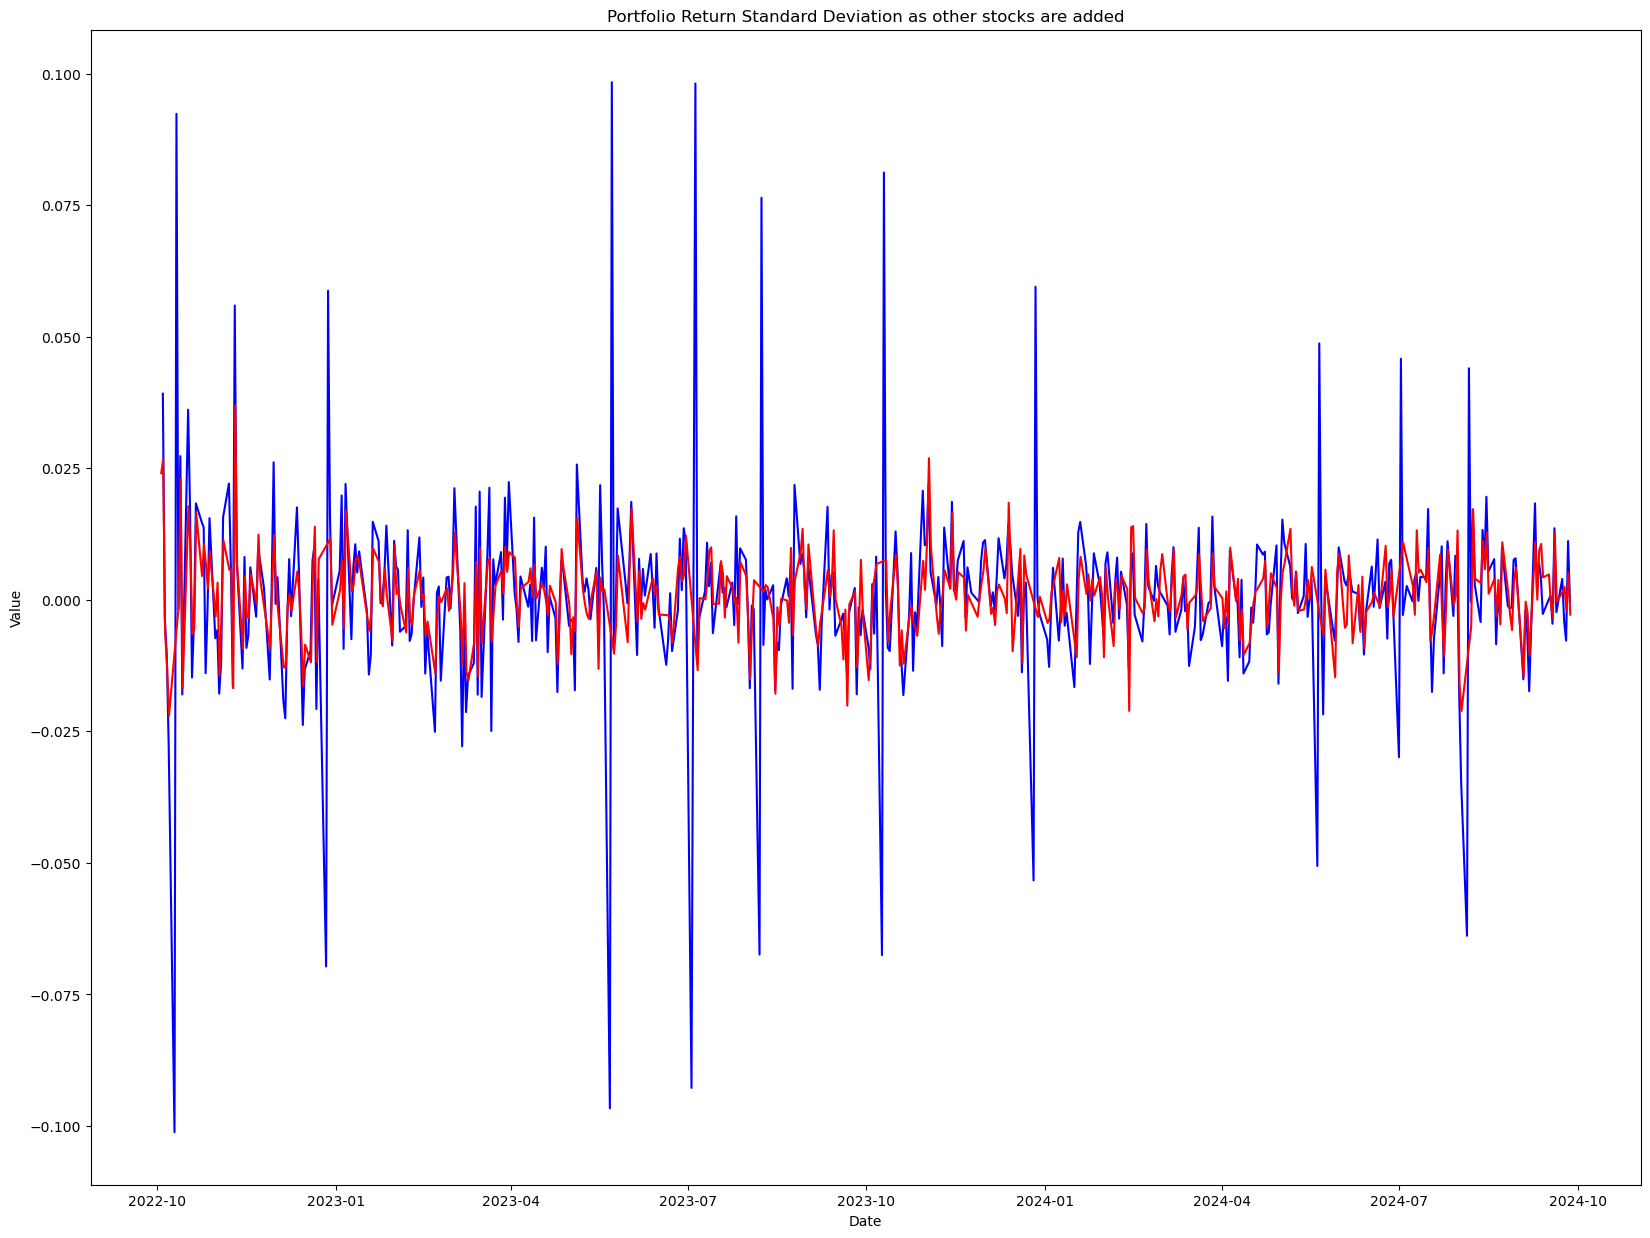

In [20]:
weights = [1/10]*10
shares = []

for i in range(len(weights)):
            allocation = amount * weights[i]  # investment allocated to this stock
            price_per_share = data.iloc[0][ticker_lst[i].upper()]
            shares.append(allocation / price_per_share)

test_portfolio = data.iloc[:, :10]*shares
test_portfolio['value'] = test_portfolio.sum(axis=1)

test_portfolio_returns = test_portfolio['value'].pct_change(fill_method=None).dropna()

snp = yf.Ticker('^GSPC').history(start=start_date, end=end_date)['Close']
tse = yf.Ticker('^GSPTSE').history(start=start_date,end=end_date)['Close']

market = (snp+tse)/2
market_returns = market.pct_change(fill_method=None).dropna()

plt.figure(figsize=(20,15))

plt.plot(test_portfolio_returns, color='b')
plt.plot(market_returns, color='r')
plt.title('Portfolio Return Standard Deviation as other stocks are added')
plt.xlabel('Date')
plt.ylabel('Value')

plt.show()

/opt/anaconda3/envs/venv/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/anaconda3/envs/venv/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstac

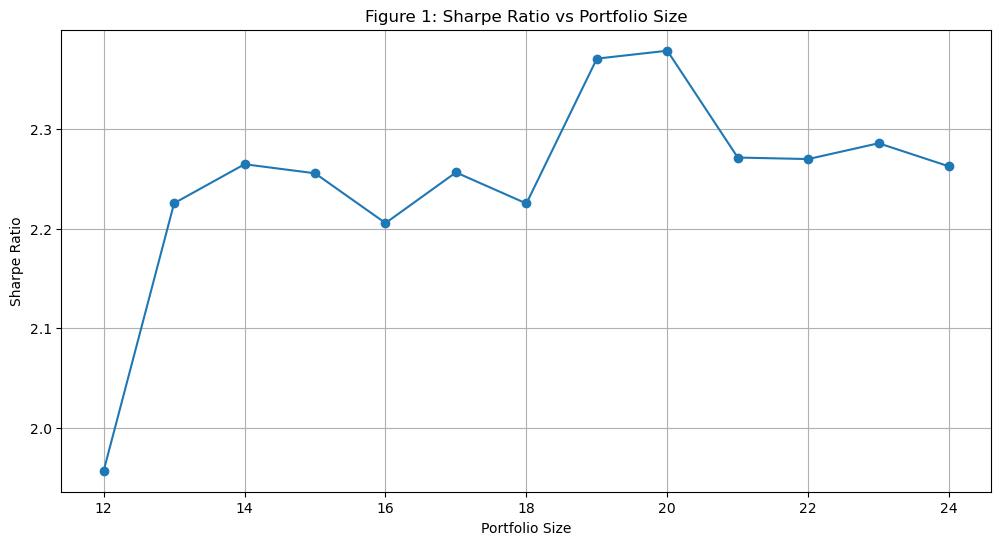

In [21]:
# Define the function to calculate Sharpe Ratios for different portfolio sizes
def sharpes_get(ticker_lst, risk_free_rate, investment, min_stocks, max_stocks):
    """
    Calculate Sharpe Ratios for different portfolio sizes and store the results in a DataFrame.
    """
    sharpes = []  # List to store Sharpe Ratios
    
    # Loop through portfolio sizes from min_stocks to max_stocks
    for i in range(min_stocks, max_stocks + 1):
        # Extract the first 'i' tickers from the list
        tickers_subset = ticker_lst[:i]
        
        # Calculate the Sharpe Ratio for the subset using optimal_sharpe function
        sharpe_ratio = -optimal_sharpe(tickers_subset, risk_free_rate, investment).fun
        
        # Append the Sharpe Ratio to the list
        sharpes.append((i, sharpe_ratio))
    
    # Convert the results to a DataFrame
    sharpes_df = pd.DataFrame(sharpes, columns=['Portfolio Size', 'Sharpe Ratio'])
    return sharpes_df


scored_tickers = scores.index.tolist()
sharpes_df = sharpes_get(scored_tickers, risk_free_rate=0, investment=amount, min_stocks=min_stocks, max_stocks=max_stocks)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(sharpes_df['Portfolio Size'], sharpes_df['Sharpe Ratio'], marker='o', linestyle='-')
plt.title('Figure 1: Sharpe Ratio vs Portfolio Size')
plt.xlabel('Portfolio Size')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()

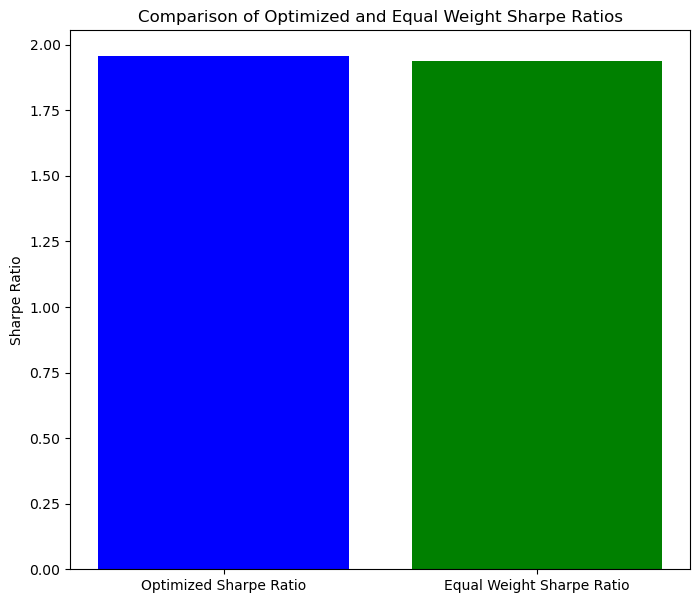

In [22]:
# Function to calculate Sharpe Ratio with equal weighting
def calculate_equal_weight_sharpe(tickers, investment, risk_free_rate=0):
    """
    Calculate Sharpe Ratio using equal weightings for the given tickers.
    """

    data = pd.DataFrame()
    for ticker in tickers:
        data[ticker] = ticker_data[ticker]

    # Number of tickers
    num_tickers = len(tickers)
    
    # Equal weights
    weights = np.array([1 / num_tickers] * num_tickers)
    
    # Determine the number of shares for each stock
    shares = []
    for i in range(num_tickers):
        allocation = investment * weights[i]  # Investment allocated to this stock
        price_per_share = data.iloc[0][tickers[i].upper()]
        
        # Calculate fees
        flat_fee = 3.95
        per_share_fee = allocation / price_per_share / (1000 + 1 / price_per_share)
        
        # Choose the smaller of the two fees
        trading_fee = min(flat_fee, per_share_fee)
        
        # Calculate the number of shares after deducting the fee
        effective_investment = allocation - trading_fee
        shares.append(effective_investment / price_per_share)
    
    # Form the portfolio
    portfolio = data[tickers] * shares
    portfolio['total'] = portfolio.sum(axis=1)
    portfolio['daily return'] = portfolio['total'].pct_change(1)
    
    # Calculate Sharpe Ratio
    er = portfolio['daily return'].mean()
    std = portfolio['daily return'].std()
    sharpe_ratio = (er - risk_free_rate) / std
    sharpe_ratio = sharpe_ratio * (252 ** 0.5)  # Annualize Sharpe Ratio

    return sharpe_ratio

# Calculate optimized Sharpe Ratio
optimized_sharpe_ratio = optimal_sharpe(scored_tickers[:12], risk_free_rate=0, investment=amount).fun * -1

# Calculate generic Sharpe Ratio using equal weighting
generic_sharpe_ratio = calculate_equal_weight_sharpe(scored_tickers[:12], amount, risk_free_rate=0)

# Prepare data for plotting
sharpe_data = {
    "Optimized Sharpe Ratio": optimized_sharpe_ratio,  # Get the last Sharpe Ratio (max stocks)
    "Equal Weight Sharpe Ratio": generic_sharpe_ratio
}

# Create the bar graph
plt.figure(figsize=(8, 7))
plt.bar(sharpe_data.keys(), sharpe_data.values(), color=['blue', 'green'])
plt.title("Comparison of Optimized and Equal Weight Sharpe Ratios")
plt.ylabel("Sharpe Ratio")
plt.show()

---
## 🏁 4. Final Output

In [23]:
print(current_best)

(2.3786052025620044, 1.1604912365550184, ['SHOP.TO', 'AMZN', 'C', 'QCOM', 'KO', 'CAT', 'LLY', 'ABT', 'AXP', 'BA', 'BAC', 'UPS', 'AAPL', 'PEP', 'BK', 'PYPL', 'PM', 'ABBV', 'BLK', 'PG'], array([0.025     , 0.06696109, 0.025     , 0.025     , 0.06571912,
       0.025     , 0.025     , 0.025     , 0.025     , 0.025     ,
       0.08450203, 0.025     , 0.26902491, 0.025     , 0.13879284,
       0.025     , 0.025     , 0.025     , 0.025     , 0.025     ]))


In [24]:
# Function to create a portfolio based on the optimized Sharpe Ratio
def portfolio_builder():
    # Store date for November, 22, 2024 in a variable:
    date1, date2 = '2024-11-22', '2024-11-23'
    final_portfolio = current_best[2]
    final_weights = current_best[3]

    portfolio = Portfolio_Final.copy()
    portfolio.Ticker = final_portfolio

    for index, ticker in enumerate(final_portfolio):
        # Get the price of the stock on the specified date
        stock = yf.Ticker(ticker).history(start=date1, end=date2)['Close'].iloc[0]
        portfolio.loc[index, 'Price'] = stock
        # Determine the number of shares to purchase based off weight
        shares = (amount * final_weights[index]) / stock
        portfolio.loc[index, 'Shares'] = shares
        # Determine the value of the stock in portfolio
        portfolio.loc[index, 'Value'] = shares * stock
        # Determine the weight of the stock in the portfolio
        portfolio.loc[index, 'Weight'] = final_weights[index]
        # Determine the currency of the ticker
        if ticker in stock_filter[2]:
            portfolio.loc[index, 'Currency'] = 'USD'
        else: portfolio.loc[index, 'Currency'] = 'CAD'
    portfolio.index = range(1, len(portfolio) + 1)
    return portfolio.head(len(final_portfolio))

portfolio = portfolio_builder()
print(f'Total Portfolio value is {np.round(portfolio["Value"].sum(), 2)}')

Total Portfolio value is 1000000.0


In [25]:
# Code to output final dataframe to a CSV file called Stocks_Group_XX.csv
Stocks_Final = Portfolio_Final[['Ticker', 'Shares']]
Stocks_Final.to_csv(f'Stocks_Group_{group}.csv', index=False)

In [28]:
Portfolio_Final = portfolio
Portfolio_Final

,Ticker,Price,Currency,Shares,Value,Weight
1,SHOP.TO,149.479996,CAD,167.246459,25000.0,0.025
2,AMZN,197.119995,USD,339.697119,66961.094473,0.066961
3,C,69.839996,USD,357.961073,25000.0,0.025
4,QCOM,156.789993,USD,159.448951,25000.0,0.025
5,KO,63.919998,USD,1028.146454,65719.119459,0.065719
6,CAT,397.48999,USD,62.894666,25000.0,0.025
7,LLY,748.01001,USD,33.422013,25000.0,0.025
8,ABT,117.760002,USD,212.296192,25000.0,0.025
9,AXP,301.299988,USD,82.973784,25000.0,0.025
10,BA,149.289993,USD,167.459315,25000.0,0.025


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

---
<p style="color: #004dd3">
Akram Jamil
</p>

<p style="color: #2C8CA9">
Jester Yang
</p>

<p style="color: #3cc19d;">
Annie Wong
</p>

---